### Load pre-trained data

In [1]:
%config Completer.use_jedi = False
### reload magic
%reload_ext autoreload
%autoreload 2
import numpy as np
# import pickle
from tqdm import tqdm
import os
from datetime import datetime
# import seaborn as sns

from utility import (load_data, count, performance, idxFromDatetime,
                     ratio_count, cal_itv_error, error_divided_by_season)
from plottingFunction import HSS_line_plot, PFD_2D, boxPlot, plotFig

sampling_rate=6

In [2]:
# load data
"""
path = "/work/dong1128/model_output/"
path = os.path.join(os.getcwd(), "repro_data")
fileList = [os.path.join(os.getcwd(), "repro_data", i) for i in sorted(os.listdir(path)) if "avg" in i]
"""
path = "/work/xc3vancechen/data/model_output/repro_data"
fileList = [os.path.join(path, fname) for fname in sorted(os.listdir(path)) if "EGU" in fname]
fileList = sorted(fileList)
# model decision
# names = ['PONI_Atten', 'PONI_Atten_Windv1', 'PONI_Atten_Windv2']
# fileList = [fileList[5], fileList[6], fileList[0]]
names = ['CPN_PONI_All', 'CPN_PONI', 'CPN']
#fileList = [fileList[5], fileList[1], fileList[2], fileList[6]]
fileList = fileList[2:]
print(fileList)

['/work/xc3vancechen/data/model_output/repro_data/BalGRUAdvPONI_addponi_mt18_dt127_EGU_hourly.pkl', '/work/xc3vancechen/data/model_output/repro_data/BalancedGRUAdvPONI_mt17_dt17_EGU_hourly.pkl', '/work/xc3vancechen/data/model_output/repro_data/BalancedGRUAdverserialAttention_mt10_dt17_EGU_hourly.pkl']


In [3]:
data_loader = load_data(*fileList, file_num = len(fileList))
all_data, target, init_t, = data_loader._return

/work/xc3vancechen/data/model_output/repro_data/BalGRUAdvPONI_addponi_mt18_dt127_EGU_hourly.pkl has been loaded.
/work/xc3vancechen/data/model_output/repro_data/BalancedGRUAdvPONI_mt17_dt17_EGU_hourly.pkl has been loaded.
/work/xc3vancechen/data/model_output/repro_data/BalancedGRUAdverserialAttention_mt10_dt17_EGU_hourly.pkl has been loaded.


In [ ]:
print(all_data[0].shape)
print(init_t[0])

In [ ]:
#print(np.nanmin(target[0]))
#print(np.count_nonzero(~np.isnan(all_data[0])))
#print("valid", np.size(all_data[0])-np.count_nonzero(~np.isnan(all_data[0])))
#print(np.sum(all_data[0][all_data[0]>=500]<1000))
print(np.isnan(target[4000])[np.isnan(target[4000]) == True].size)
print((np.isnan(all_data[0])[np.isnan(all_data[0]) == True].size)/(all_data[0].size))

### calculate CSI score

In [ ]:
CSI_container = []
for d in tqdm(all_data, ncols=60):
    for t in range(3): # target_len
        verify_score = performance(d[::,:,t].squeeze(), target[::,t])
        CSI_container.append(verify_score._CSI[None])
CSI_score = np.split(np.concatenate(CSI_container, axis = 0), len(fileList)) # [N][3, 8]

# count number
numbers = count(target[:,0])

### plot

In [ ]:
HSS_line_plot(names, *CSI_score, numbers=numbers)

### performance diagram

In [ ]:
tar_t = 0 # 0 or 1 or 2
preds = [x[:, 0, tar_t] for x in all_data]
PFD_2D(preds, target[:, tar_t], thresholds = [1,3,5,10,15,20,30,40,50,60,70], names = names)
''' 0-3 acum'''
#preds = [x[:, 0].sum(axis=1) for x in all_data]
#PFD_2D(preds, target.sum(axis=1), thresholds = [10,20,30,40,50,70,100], names = names)

### Ratio

In [ ]:
l = [0,1,3,5,8,10,15,20,25,30,35,40,45,50]
tar_t = 2 # 0 or 1 or 2
input_data = [x[:, 0, tar_t] for x in all_data]
ratios = ratio_count(input_data, target[:, tar_t], threshold = l).start() #[N][len(l)]

In [ ]:
from matplotlib.patches import Patch
import matplotlib.pyplot as plt
COLORS = ['C9', 'C1', 'C2', 'C3', 'C4']
fig, ax = plt.subplots(1, 1, num='result', figsize=(7, 5.6), dpi=200, facecolor='w')
plt.plot(l,ratios[0],color="C9", alpha=0.6, zorder=5)
plt.fill_between(l, 0, ratios[0], facecolor="C9", alpha = 0.5, zorder=5)
for i in range(1, len(ratios)):
    plt.plot(l,ratios[i],color="C"+str(i), alpha=0.6)
    plt.fill_between(l, 0, ratios[i], facecolor="C"+str(i), alpha = 0.5)
ax.set_xlim(0, 50)
ax.set_xticks(np.arange(0,55,5))
ax.set_xticklabels(np.arange(0,55,5),fontsize=10)
# ax.set_yticks(np.arange(0,3,0.5)) # 0-1
# ax.set_ylim(bottom=0, top=2.5)
# ax.set_yticks(np.arange(0, 8)) # 1-2
# ax.set_ylim(bottom=0, top=7)
ax.set_yticks(np.arange(0,13)) # 2-3
ax.set_ylim(bottom=0, top=12)
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(a) for a in vals],fontsize=10)
ax.grid(zorder=-2,alpha=0.4)
handles = [
    Patch(facecolor=color, label=label, alpha=0.7) 
    for label, color in zip(names, COLORS)
]
ax.legend(handles=handles, edgecolor='black',fontsize=10)

### Box error

In [4]:
tar_t = 0 # 0 or 1 or 2
data_for_error = [x[:, 0, tar_t] for x in all_data]
target_for_error = target[:,tar_t] # [B, H, W]
bias = cal_itv_error(data_for_error, target_for_error, [0,1,3,5,10,15,20,30,40])
ticks_name = ['0~1', '1~3', '3~5', '5~10', '10~15', '15~20', '20~30', '30~40', '>= 40']
''' 3-h accu '''
# data_for_error = [x[:, 0].sum(axis=1) for x in all_data]
# target_for_error = target.sum(axis=1) # [B, H, W]
# bias = cal_itv_error(data_for_error, target_for_error, [0,10,30,50,70,100,130,200])
# ticks_name = ['0~10 mm', '10~30', '30~50', '50~70', '70~100', '100~130', '>=130'] # not plot >200mm

100%|█████████████████████████| 3/3 [03:11<00:00, 63.97s/it]


' 3-h accu '

In [17]:
print(bias[2])

[array([0.        , 0.        , 0.        , ..., 0.        , 0.        ,
       0.00146438], dtype=float32), array([ 1.5232986 ,  1.5152485 ,  2.2981071 , ..., -0.12763125,
       -0.2810362 ,  0.71494687], dtype=float32), array([ 1.8797066, -2.2707086,  2.356303 , ..., -3.5597172, -3.5484443,
       -2.3315134], dtype=float32), array([ 0.49417686,  0.95185566, -4.6063256 , ..., -3.1672816 ,
       -4.740034  , -4.745127  ], dtype=float32), array([ -7.9694014,  -7.8775644, -10.203663 , ..., -11.177962 ,
       -10.512893 , -11.164747 ], dtype=float32), array([-19.       , -18.99999  , -15.495844 , ...,  -4.1600494,
        -7.881633 ,  -9.307211 ], dtype=float32), array([-20.165869, -22.833334, -22.983019, ...,  -9.592762, -13.887998,
       -11.69644 ], dtype=float32), array([-28.23657 , -28.043198, -28.324799, ..., -19.243576, -15.9694  ,
       -20.146835], dtype=float32), array([-18.394735, -24.942549, -26.808014, ..., -29.559742, -17.11761 ,
       -22.436956], dtype=float32)]


3


  0%|                                 | 0/3 [00:00<?, ?it/s]/home/xc3vancechen/anaconda3/envs/DLRA_env_v3/lib/python3.8/site-packages/numpy/core/_methods.py:180: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
 33%|████████▎                | 1/3 [00:18<00:37, 18.59s/it]/home/xc3vancechen/anaconda3/envs/DLRA_env_v3/lib/python3.8/site-packages/numpy/core/_methods.py:180: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
100%|█████████████████████████| 3/3 [00:55<00:00, 18.46s/it]


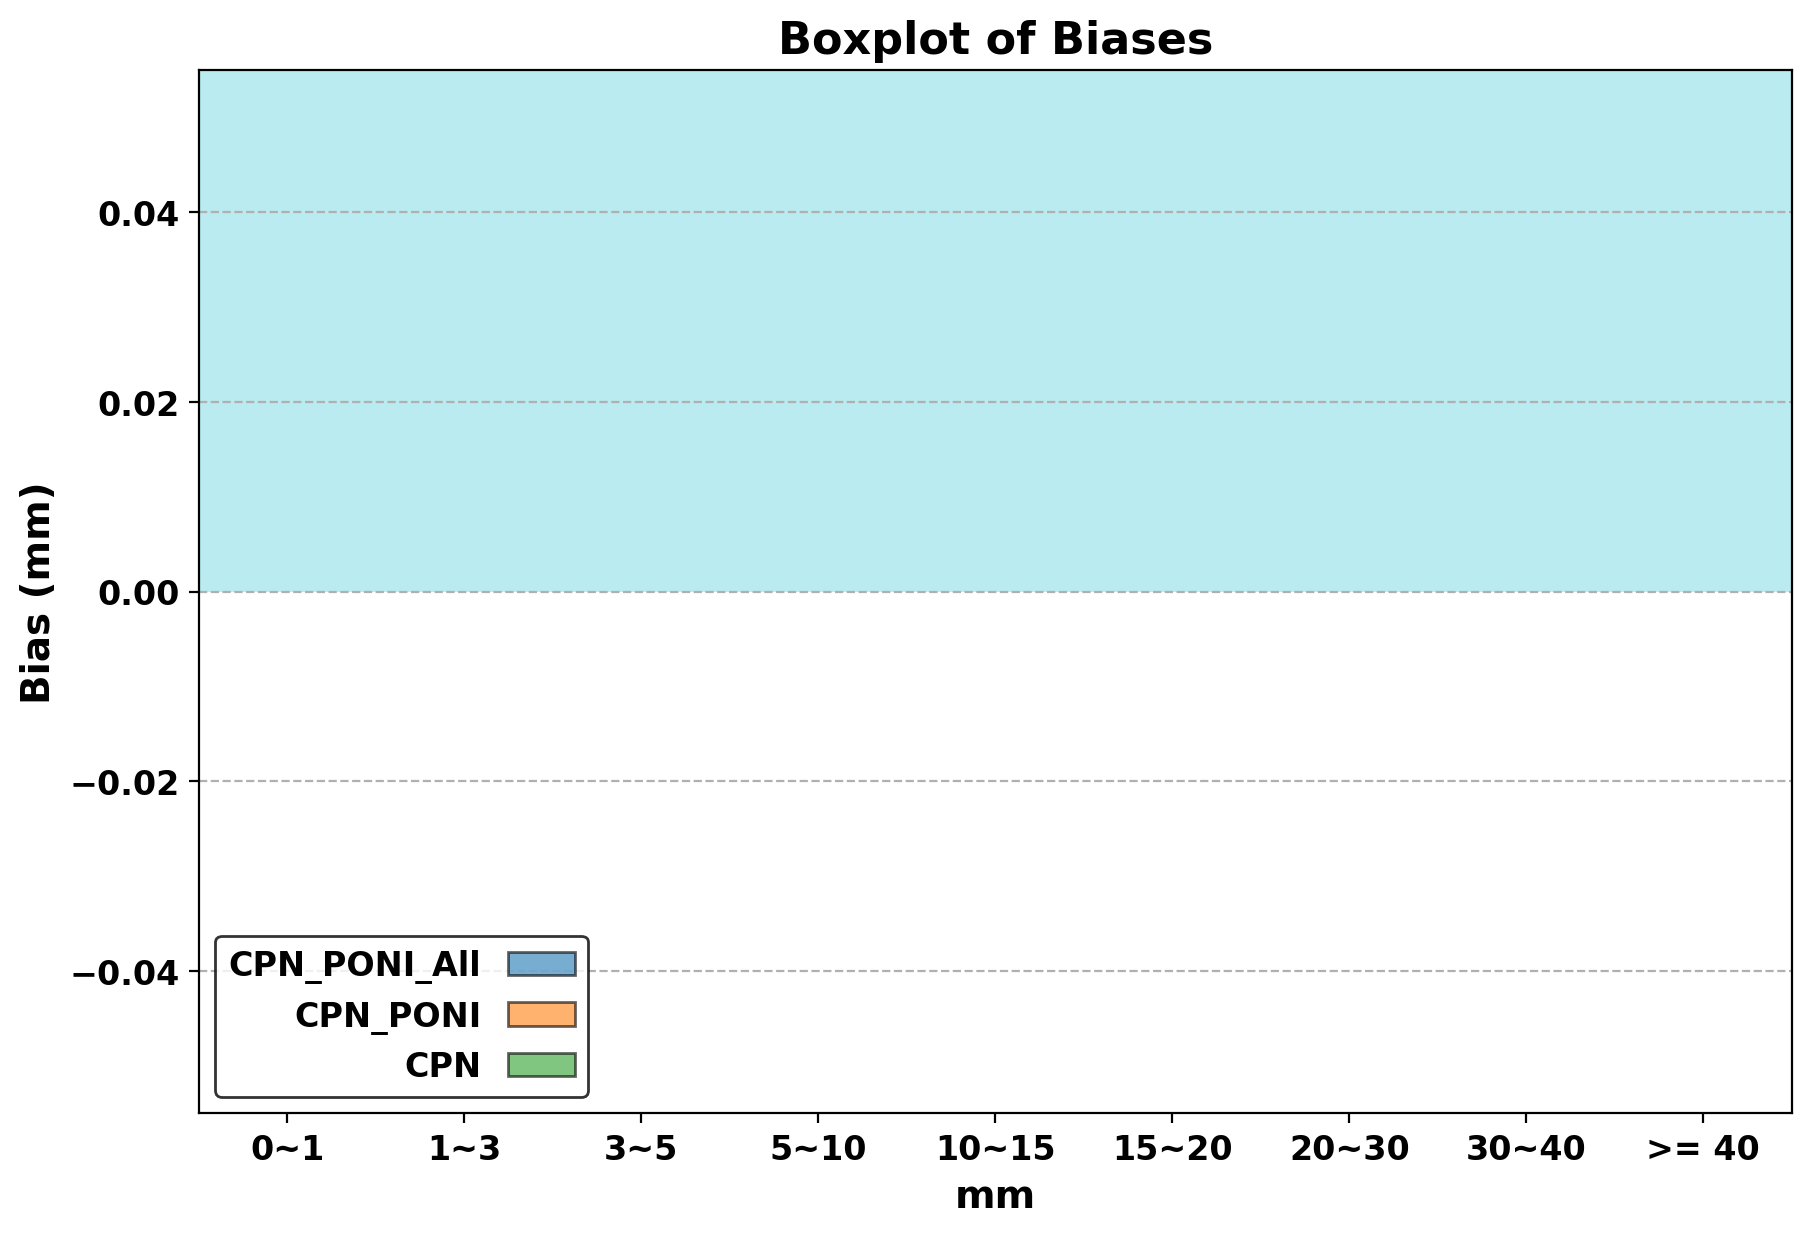

In [18]:
boxPlot(bias, names, ticks_name)

### Season check

In [ ]:
tar_t = 0 # 0 or 1 or 2
# data_for_season = [x[:, 0, tar_t] for x in [all_data[0], all_data[1]]]
# target_for_season = target[:,tar_t] # [B, H, W]
# bias_season = error_divided_by_season(data_for_season, target_for_season, init_t, [0,1,3,5,10,15,20,30,40])\
#                    .cal_error()
''' 3 hr '''
data_for_season = [x[:, 0].sum(axis=1) for x in [all_data[0], all_data[1]]]
target_for_season = target.sum(axis=1) # [B, H, W]
bias_season = error_divided_by_season(data_for_season, target_for_season, init_t, [0,10,30,50,70,100,130,200])\
                   .cal_error()

In [ ]:
names_season = ['PONI(summer)', 'PONI(winter)', 'Wind(summer)', 'Wind(winter)']
# ticks_name = ['0~1', '1~3', '3~5', '5~10', '10~15', '15~20', '20~30', '30~40', '>= 40']
ticks_name = ['0~10 mm', '10~30', '30~50', '50~70', '70~100', '100~130', '>=130'] # not plot >200mm
boxPlot(bias_season, names_season, ticks_name)

### Simple verification

In [ ]:
### settings
# 2018/5/7 16:10 鋒面
# 2019/5/28 5:10~13:00 LST front case
# 2019/5/20 8:00 LST chimney cloud
# 2019/7/22 13:00 LST ATS
# 2019/9/30 9:50 TC. Mitag
# 2019/12/30 23:00 東北季風
# 2021/6/4 3:10 台北暴雨
# 2021/10/16 5:10 虎豹潭事件

# rainfall event
idx = idxFromDatetime(init_t, datetime(2021,6,4,3,10))
# idx = idxFromDatetime(init_t, datetime(2021,10,16,5,10))
# idx = idxFromDatetime(init_t, datetime(2019,9,30,9,50))
backoff_num = int((6 / sampling_rate) * 2)
event = np.concatenate([target[idx-backoff_num:idx+8, 0:1], all_data[2].squeeze()[idx-backoff_num:idx+8]], axis=1)
plotFig(init_t[idx:idx+8], event, backoff_num)